# Overall Strategy
- Use newsAPI to find companies that are trending (week 1)
- Use kaggle dataset to find patterns in stock trades (week 2)
- Use fmpCloud API to calculate P/E to determine if stock has future potential Long term investment(week 3)
- Combine all strategies to make estimates on stocks that should be invested in.
    - Strategies that proved more sucessful in the end will have more weight

*notes: using NASDAQ*

### Week 1

- NewsApi will search for articles that include the stock ticker
- Based on article count we know which companies are being talked about more
    - Hopefully in a good way (Will hopefully adjust for this later)
- Using top 50 Companies based on Market Cap
- Output includes company name + Article count
- Based on this we can invest in the companies being talked about the most.

In [58]:
!pip install spacy
!pip install newsapi-python
!pip install fsspec
!pip install pandas_datareader

In [50]:
#import libraries
from newsapi import NewsApiClient
import pandas as pd
import json
import csv

# top 50 traded Companies by Market CAP
# Limited to 50 since API only allows 100 request perday with free account
companies = ['Apple','Microsoft','Google','Alphabet','Amazon','Tesla','Facebook','Nvidia','Taiwan Semiconductor','JP Morgan',
             'Visa','Home Depot','Johnson & Johnson','United Health','ADI','Bank of America','Walmart','Alibaba','GameStop','Procter & Gamble',
             'Mastercard','Adobe','Netflix','NTES','CRM','Pfizer','Disney','Nike','Exxon','Novo',
             'Oracle','Toyota','Thermo','Eli Lilly','Comcast','Coca-Cola','AMC','Paypal','Rivian','Costco',
             'Cisco','PEPSI','Abbott Laboratories','Danaher','Chevron','Verizon','Shopify','Merck & Company','Qualcomm','AbbVie']

#Used for testing (ignore)
test_companies = ['AAPL','PEPSI','TSLA']

#Init
newsapi = NewsApiClient(api_key='3eaeabeef28c459d96502d7c196ac421')

In [54]:
article_results = []

for x in range(50):
    #used to filter searches that mention the stock market in realtion to company
    q = companies[x]+' NASDAQ'
    data = newsapi.get_everything(q=q,from_param='2021-11-29',
                                      to='2021-12-02', language='en', page_size=0) #Change Dates
    article_results.append(data['totalResults'])

list_of_results = list(zip(companies, article_results))
df = pd.DataFrame(list_of_results, columns = ['company','results'])
df.sort_values('results')
print(df)

                 company  results
0                  Apple      145
1              Microsoft      119
2                 Google      136
3               Alphabet       39
4                 Amazon      138
5                  Tesla       65
6               Facebook      251
7                 Nvidia       47
8   Taiwan Semiconductor        5
9              JP Morgan       12
10                  Visa       16
11            Home Depot        7
12     Johnson & Johnson       49
13         United Health      185
14                   ADI       11
15       Bank of America       58
16               Walmart       32
17               Alibaba       21
18              GameStop       14
19      Procter & Gamble        1
20            Mastercard       18
21                 Adobe       15
22               Netflix       25
23                  NTES        0
24                   CRM       33
25                Pfizer       70
26                Disney       17
27                  Nike       16
28            

In [56]:
df.to_excel("output.xlsx")

# Results from Day 1
 I ajdusted the names to be the full name. Just using the stock ticker name produced very little results for some. And some tickers produced un-realted results

# List
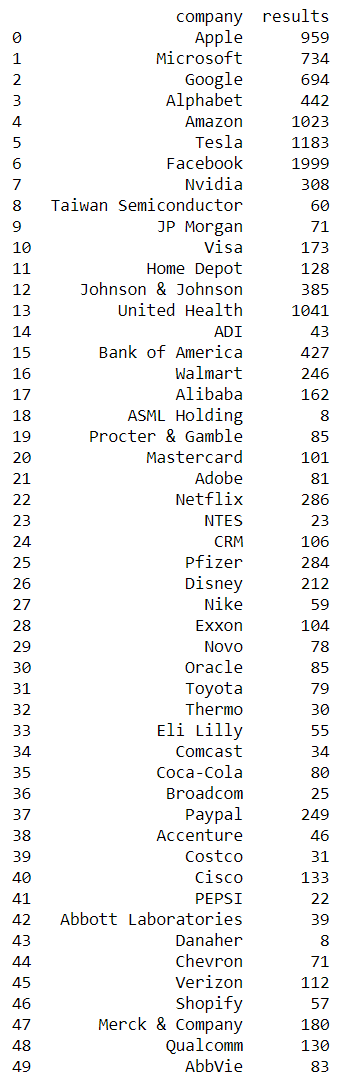


### Stock Buys
- Facebook had the most hits with 1999 
    - Bought 30k shares 11/18/21 (Pre-market)
- Tesla had 2 most with 1183
    - Bought 20k shares 11/18/21 (Pre-Market)
- United Health was 3rd with 1041
    - Bought 10k shares 11/18/21 (Pre-Market)

## Results after day 1
- My total gain is 2.58

# Week 2
## Data Prediciton
- making preditions based on real data
- making prediction on closing price

### Strategy
- Check the predicted Next day price for Companies I am invested in
- Check companies that look of interest

In [60]:
!pip install tensorflow

  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=2037d452c8ff85cad14854d534b092aac6c941e755d43ea57a79ce796794c269
  Stored in directory: c:\users\abrah\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import sklearn

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [139]:
#Load data
company = 'PFE'
start = dt.datetime(2018,1,1)
end = dt.datetime(2021,1,1)

data = web.DataReader(company, 'yahoo', start, end) #Load from yahoo finance database

In [140]:
#prepare data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60  #how many days we are looking back to base new predicted price on

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [141]:
#Build Neural Network Model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
22/22 [==============================] - 4s 40ms/step - loss: 0.0884
Epoch 2/25
22/22 [==============================] - 1s 39ms/step - loss: 0.0152
Epoch 3/25
22/22 [==============================] - 1s 40ms/step - loss: 0.0138
Epoch 4/25
22/22 [==============================] - 1s 38ms/step - loss: 0.0117
Epoch 5/25
22/22 [==============================] - 1s 40ms/step - loss: 0.0106
Epoch 6/25
22/22 [==============================] - 1s 38ms/step - loss: 0.0098
Epoch 7/25
22/22 [==============================] - 1s 38ms/step - loss: 0.0100
Epoch 8/25
22/22 [==============================] - 1s 42ms/step - loss: 0.0089
Epoch 9/25
22/22 [==============================] - 1s 41ms/step - loss: 0.0097
Epoch 10/25
22/22 [==============================] - 1s 40ms/step - loss: 0.0095
Epoch 11/25
22/22 [==============================] - 1s 41ms/step - loss: 0.0086
Epoch 12/25
22/22 [==============================] - 1s 39ms/step - loss: 0.0090
Epoch 13/25
22/22 [==================

In [142]:
#Load Test Data
test_start=dt.datetime(2020, 1, 1)
test_end=dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices=test_data['Close'].values

total_dataset=pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs=total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [143]:
# Make Predictions on Test Data
x_test=[]

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

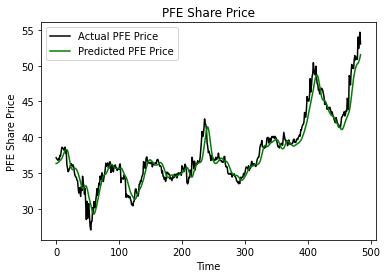

In [144]:
# Plot the test predictions
plt.plot(actual_prices, color = "black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
plt.show()

In [145]:
#Predict Next Day

real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs+1), 0]] 
real_data = np.array(real_data)
real_data=np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

prediction=model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[51.94818]]


# *Results* (11/24/21)
## Current Portfolio
 - FB Prediction: [[325.46506]] Current: 341.06  --> Sell
 - TSLA Prediction: [[1004.28436]] Current: 1116.00 --> Sell
 - UNH Prediction: Prediction: [[442.34647]] Current: 450.16 --> Sell
 
## New Options Based on NewsApi Stats
- Amazon Prediction: [[3556.087]] current: 3580.41 --> no
- Rivian N/A not enough data for model --> Buy 5k based on News API (test)
- Walmart Prediction: [[147.09341] current: 146.54 --> Buy 20k worth of shares
- Nvidia Prediction: [[333.25783]] current: 326.74 --> Buy 90K worth of shares
- Facebook --> buy 10k back
    - had unusally high results from news API

# Week 3

## Current Portfolio Results (12/3/21)
 - FB: Down 7.57%
 - NVDA: Down 1.45%
 - RIVN: Down 0.21%
 - WMT: Down 7.49%
 - Class Rank 7 out of 36
 
## New Options Based on NewsApi and Closing Prediciton Model
### Top 5 Performers
    - FB, UNH, AAPL, AMZN, GOOG
    - Honorable Mentions: Pfizer, Bank of America, Johnson and Johnson
    
### Closing Predictions
- FB Prediction: [[330.18924]] --> current [310.39] buy more (Bought 161 shares)
- NVDA: Prediction: [[343.79858]] --> current [321.26] buy more (Bought 125 shares)
- WMT: Prediction: [[143.4884]] --> Current [135.47] Buy more (Bought 295 shares)
- UNH: Prediction: [[441.81848]] --> Current [446.02] ignore
- AAPL: Prediction: [[149.93184]] --> Current [163.76] ignore
- AMZN: Prediction: [[3475.2175]] --> Current [3437.36] ignore
- GOOG: Prediction: [[2667.1052]] --> Current [2875.53] ignore
- PFE: Prediction: [[51.94818]] --> current [53.04] ignore


*note week 3 did not go as planed could not get data anlysis model to work in time to make trades. Will attempt again for week 4. 

P/E = Share Price/ Earnings Per Share

In [30]:
!pip install mplfinance

In [43]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import mplfinance as mpf
import datetime
import warnings
warnings.filterwarnings('ignore')

In [44]:
#Used to test Individual Stocks
#Get Data from Financial Modeling Prep.com
import requests
stock = 'WMT'

# access income statements
income_statement = requests.get("https://financialmodelingprep.com/api/v3/income-statement/"+ stock + "?limit=120&apikey=2557fb8efd0ac3cf0644cdfcd76fa8b6")
income_statement = income_statement.json()
income_statement

[{'date': '2021-01-31',
  'symbol': 'WMT',
  'reportedCurrency': 'USD',
  'cik': '0000104169',
  'fillingDate': '2021-03-19',
  'acceptedDate': '2021-03-19',
  'calendarYear': '2021',
  'period': 'FY',
  'revenue': 559151000000,
  'costOfRevenue': 420315000000,
  'grossProfit': 138836000000,
  'grossProfitRatio': 0.24829786587165184,
  'researchAndDevelopmentExpenses': 0.0,
  'generalAndAdministrativeExpenses': 0.0,
  'sellingAndMarketingExpenses': 0.0,
  'sellingGeneralAndAdministrativeExpenses': 116288000000,
  'otherExpenses': 0.0,
  'operatingExpenses': 116288000000,
  'costAndExpenses': 536603000000,
  'interestIncome': 121000000,
  'interestExpense': 2315000000,
  'depreciationAndAmortization': 11152000000,
  'ebitda': 33835000000,
  'ebitdaratio': 0.06051138243515616,
  'operatingIncome': 22548000000,
  'operatingIncomeRatio': 0.03677718541145415,
  'totalOtherIncomeExpensesNet': 1984000000,
  'incomeBeforeTax': 20564000000,
  'incomeBeforeTaxRatio': 0.03677718541145415,
  'inco

In [45]:
eps = income_statement[0]['eps']
eps

4.77

In [46]:
net_income = income_statement[0]['netIncome']
net_income

13510000000

In [47]:
# access company profile
profile = requests.get("https://financialmodelingprep.com/api/v3/profile/"+ stock +"?apikey=2557fb8efd0ac3cf0644cdfcd76fa8b6" )
profile = profile.json()
profile

[{'symbol': 'WMT',
  'price': 137.51,
  'beta': 0.508571,
  'volAvg': 7757803,
  'mktCap': 388172840960,
  'lastDiv': 2.1900000000000004,
  'range': '126.28-152.57',
  'changes': 2.0399933,
  'companyName': 'Walmart Inc.',
  'currency': 'USD',
  'cik': '0000104169',
  'isin': 'US9311421039',
  'cusip': '931142103',
  'exchange': 'New York Stock Exchange',
  'exchangeShortName': 'NYSE',
  'industry': 'Discount Stores',
  'website': 'http://www.stock.walmart.com',
  'description': "Walmart Inc. engages in the retail and wholesale operations in various formats worldwide. The company operates in three segments: Walmart U.S., Walmart International, and Sam's Club. It operates supercenters, supermarkets, hypermarkets, warehouse clubs, cash and carry stores, discount stores, drugstores, and convenience stores; membership-only warehouse clubs; ecommerce websites, such as walmart.com, walmart.com.mx, asda.com, walmart.ca, flipkart.com, and samsclub.com; and mobile commerce applications. The com

In [48]:
price = profile[0]['price']
price

137.51

In [49]:
p_e_ratio = float(price)/float(eps)
p_e_ratio

28.828092243186582

In [64]:
#Check 50 Companies
# stocks of the NASDAQ
nas_symbols = pd.read_csv('nasdaq_100.csv', sep='\t')

companies = ['AAPL','MSFT','GOOG','GOOGL','AMZN','TSLA','FB','NVDA','TSM','JPM',
             'V','HD','JNJ','UNH','ADI','BAC','WMT','BABA','GME','PG',
             'MA','ADBE','NFLX','NTES','CRM','PFE','DIS','NKE','XOM','NVO',
             'ORCL','TM','TMO','LLY','CMCSA','KO','AMC','PYPL','RIVN','COST',
             'CSCO','PEP','ABT','DHR','CVX','VZ','SHOP','MRK','QCOM','ABBV']


In [65]:
import time

pe_ratios = []
for symbol in companies:
    print(symbol)
    
    # access income statements
    income_statement = requests.get("https://financialmodelingprep.com/api/v3/income-statement/"+ symbol + "?limit=120&apikey=2557fb8efd0ac3cf0644cdfcd76fa8b6" )
    income_statement = income_statement.json()
    net_income = income_statement[0]['netIncome']
    eps = income_statement[0]['eps']
    
    
    # access company profile
    profile = requests.get("https://financialmodelingprep.com/api/v3/profile/"+ symbol +"?apikey=2557fb8efd0ac3cf0644cdfcd76fa8b6" )
    profile = profile.json()
    price = profile[0]['price']
    
    if eps != '' and price !='':
        print('P/E:', np.round(float(price)/float(eps),2))
        
    else:
        print('Missing fundamental data')
        

    
    # be a good netizen
    time.sleep(1)
     

AAPL
P/E: 28.55
MSFT
P/E: 39.78
GOOG
P/E: 48.19
GOOGL
P/E: 48.01
AMZN
P/E: 79.5
TSLA
P/E: 1371.58
FB
P/E: 30.02
NVDA
P/E: 174.89
TSM
P/E: 1.2
JPM
P/E: 17.81
V
P/E: 34.87
HD
P/E: 34.04
JNJ
P/E: 28.52
UNH
P/E: 27.65
ADI
P/E: 54.62
BAC
P/E: 23.34
WMT
P/E: 28.83
BABA
P/E: 2.01
GME
P/E: -52.08
PG
P/E: 26.34
MA
P/E: 50.33
ADBE
P/E: 56.36
NFLX
P/E: 96.19
NTES
P/E: 5.48
CRM
P/E: 57.66
PFE
P/E: 31.37
DIS
P/E: 106.03
NKE
P/E: 46.77
XOM
P/E: -11.49
NVO
P/E: 5.93
ORCL
P/E: 18.9
TM
P/E: 0.11
TMO
P/E: 39.53
LLY
P/E: 37.93
CMCSA
P/E: 22.52
KO
P/E: 29.74
AMC
P/E: -0.66
PYPL
P/E: 51.38
RIVN
P/E: -30.16
COST
P/E: 46.81
CSCO
P/E: 22.49
PEP
P/E: 31.92
ABT
P/E: 51.33
DHR
P/E: 62.97
CVX
P/E: -38.65
VZ
P/E: 11.96
SHOP
P/E: 528.09
MRK
P/E: 26.26
QCOM
P/E: 22.09
ABBV
P/E: 45.45


# Stocks with Good P/E Ratios

- UNH: P/E: 27.65 --> BUY
- HD: HD P/E: 34.04 --> BUY

# Stock with BAD P/E Ratios
- RIVN (P/E: -30.16) --> SELL (ALL)
    - possible because its a new stock
- NVDA (P/E: 174.89) --> SELL (To High)